<a href="https://colab.research.google.com/github/NastaCom/ML_for_business/blob/main/HW_5_ML_GorokhovaA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Case 1

набор данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [ ]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [ ]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

Зададим списки признаков

In [ ]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Аналогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

In [ ]:
numr = Pipeline([
                ('selector', NumberSelector(key='CreditScore')),            
            ])

numr.fit(X_train)
numr.transform(X_test).head(3)

,CreditScore
9394,597
898,523
2398,706


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [ ]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [ ]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])
#feature_processing

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим и обучим модель(по заданию экспериментируем с бустингом и логистической регрессией)

##### Буду использовать модели без настройки параметров ( (не получается вариант с помощью GridSearch (из-за нехватки моих знаний)). Интереснее было бы перебрать сразу все 3 модели с подборкой лучших параметров и так же обучить... , но после многих неудачный попыток буду работать со стандартными параметрами и по отдельности ((((

In [ ]:
models_results = {
    'approach': [],
    'F-Score': [],
    'Precision': [],
    'Recall': [],
}

### RandomForestClassifier

In [ ]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42))
    ])

In [ ]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [ ]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629


Отрисуем матрицу ошибок

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1793  198]
 [ 188  321]]


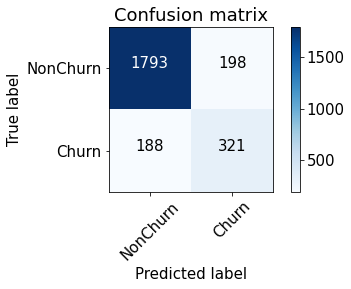

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
models_results['approach'].append('RandomForestClassifier')
models_results['F-Score'].append(0.641)
models_results['Precision'].append(0.654)
models_results['Recall'].append(0.629)

### LogisticRegression

In [ ]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

для логистической регресси выполню масштабирование

In [ ]:
scaler_std = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train_norm[continuous_columns] = scaler_std.fit_transform(X_train_norm[continuous_columns])
X_test_norm[continuous_columns] = scaler_std.transform(X_test_norm[continuous_columns])

In [ ]:
pipeline.fit(X_train_norm, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [ ]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test_norm)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Confusion matrix, without normalization
[[1793  198]
 [ 188  321]]


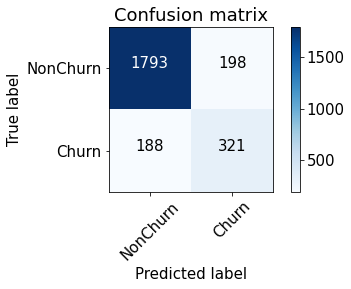

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
models_results['approach'].append('LogisticRegression')
models_results['F-Score'].append(0.510)
models_results['Precision'].append(0.462)
models_results['Recall'].append(0.568)

### XGBClassifier

In [ ]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state = 42)),
])

In [ ]:
pipeline.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [ ]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.47611395, 0.23087966, 0.0737261 , 0.03141731, 0.02561874,
       0.9679959 , 0.06951059, 0.2885457 , 0.11367497, 0.4902508 ],
      dtype=float32)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633


Confusion matrix, without normalization
[[1793  198]
 [ 188  321]]


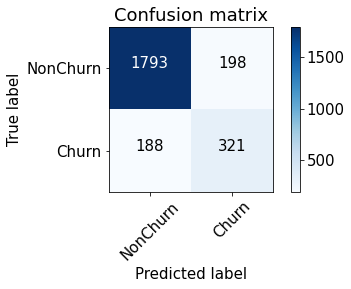

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
models_results['approach'].append('XGBClassifier')
models_results['F-Score'].append(0.626)
models_results['Precision'].append(0.619)
models_results['Recall'].append(0.633) 

In [ ]:
pd.DataFrame( models_results)

,approach,F-Score,Precision,Recall
0,RandomForestClassifier,0.641,0.654,0.629
1,LogisticRegression,0.510,0.462,0.568
2,XGBClassifier,0.626,0.619,0.633


LogisticRegression по всем метрикам плохо себя показала. RandomForestClassifier мы разбирали на вебинаре. Поэтому поработаю с XGBClassifier. Все модели со стандартными параметрами. Понимаю, что можно повысить результаты за счет гиперпараметров, но пока у меня не получается компактно использовать GridSearchCV разом на все используемые модели. А если по-отдельности на каждую модель, то огромная портянка получается. 


По поводу метрик... постараюсь ответить коротко

Очевидно, что мы не можем находить всех уходящих в отток клиентов и только их. Но, определив стратегию для удержания клиентов, мы можем подобрать нужные пороги по precision и recall. Например, можно сосредоточиться на удержании только высокодоходных клиентов или тех, кто уйдет с большей вероятностью, так как мы ограничены в ресурсах колл-центра.
F-Score — среднее гармоническое precision и recall. F-Score достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю. 

Для задачи оттока, думаю, F-Score самая подходящая метрика, т.к. она держит баланс между метриками, но лучше смотреть на нее с большим уклоном на precision (precision обеспечивает максимальное содержание TP в предсказаниях модели, а значит мы не будем тратить неэффективно бюджет на FP)
Хотя, если мы хотим охватить больше клиентов, то ориентируемся по recall

### Оценка экономической эффективности

In [ ]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

TN, FP, FN, TP

(1793, 198, 188, 321)

In [ ]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.630648330058939, 0.09944751381215469, 0.9005524861878453)

FPR (False Positive Rate) 0.091. Это значит, что 9.1 % клиентов определяются как "готовые к оттоку" некоректно

In [ ]:
retain_sum = (FP + TP) * 1
print(f'На удержание мы потратим 1 USD (321 (TP) + 198 (FP)) = {retain_sum} USD') 

На удержание мы потратим 1 USD (321 (TP) + 198 (FP)) = 519 USD


In [ ]:
income = TP * 2
print(f'а заработаем 321 (TP) * 2 USD = {income} USD') 

а заработаем 321 (TP) * 2 USD = 642 USD


In [ ]:
print(f'Итого мат.ожидание модели 642 USD - 519 USD = {income - retain_sum} USD')

Итого мат.ожидание модели 642 USD - 519 USD = 123 USD
